# Connections that Matter: A Social Network Analysis of Import Trades

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### 1.Introduction


This project conducts a thourogh analysis of the relationships between countries who participated in import trade through Social Network Analysis (SNA). Initially, the dataset is imported, then cleaned and manipulated into the corect format for social network analysis. Various centrality measures within the network are then calculated and visualized. Using weighted eigenvector centrality, the top 50 importing countries are identified and vizualised on a global map, showcasing the complexity of international trade in a social network. And to complete the analysis, the 5 top markets are shown for each top 10 importing country. 

### 2.Data import



The dataset used for this project is from __World Bank Group__ specifically it can be found in the data catalog under the name __Market Composition & Growth Import__. Only the year of __2022__ is used for this project, as this project is focused on the relationships between countries in the context of import trades.  The dataset can be dowloaded in a ZIP file, therefore first step is to open the ZIP file, and extract the CSV file containing the datset. Because the ZIP file only has one CSV, the pandas package is able to automatically detect and extract one single CSV file from the ZIP file.

The dataset __trades__ is formed of 10 columns and 8,261,706 rows. The dataset contains the country who imports the goods under the column-'ReporterISO3' and the country where the goods are coming from -'PartnerISO3' as well as the trade value-'TradeValue_EndYear', there are other columns in the dataset but in this project those columns are not needed. 

Another dataset __country_code__ is added to this project, as a bridge to vizualise better the results, as in the first dataset the countries are inserted by their Alpha-3 code rather than name, as such this second datset has the name of countries, their Alpha-3 code, and latitude and longitude, which will facilitate in the later part of project with visualisation. 

To download the data please follow these steps:

In [2]:
trades = pd.read_csv('og_rank_market_2022_import_csv.zip')
URL1 ='https://gist.githubusercontent.com/metal3d/5b925077e66194551df949de64e910f6/raw/c5f20a037409d96958553e2eb6b8251265c6fd63/country-coord.csv'
country_code = pd.read_csv(URL1)
country_code.to_csv('country_code.csv',index=False,header=True)

In [3]:
trades.head(5)

,ReporterISO3,PartnerISO3,ProductCode,StartYear,EndYear,TradeFlow,Nomenclature,TradeValue_EndYear,PercentOfTotal_EndYear,Rank
0,ABW,USA,20622,2021,2022,Import,H0,62.78,93.701,1
1,SVK,PHL,440920,2021,2022,Import,H0,0.02,0.000,41
2,ABW,UNS,20622,2021,2022,Import,H0,4.23,6.313,2
3,ABW,USA,70519,2021,2022,Import,H0,2779.83,93.092,1
4,SVK,HKG,440920,2021,2022,Import,H0,0.01,0.000,43


In [4]:
trades.shape

(8261706, 10)

In [5]:
country_code.head(5)

,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
0,Afghanistan,AF,AFG,4,33.0000,65.0
1,Albania,AL,ALB,8,41.0000,20.0
2,Algeria,DZ,DZA,12,28.0000,3.0
3,American Samoa,AS,ASM,16,-14.3333,-170.0
4,Andorra,AD,AND,20,42.5000,1.6


### 3.Data cleaning and manipulation

This project's primary goal is to explore the relationships of countries rather than individual trade products, this will be done through conducting a Social Network Analysis. 
As such, summing the trade amounts for each country pair across all product types, will result in simplifying the data and will help highlight the trade relationships between countries, excluding the complexity that each imported product type adds. As such, first step is to manipulate the dataset into grouping the country pairs and summing the trade value of all products, then add a new dataframe that contains only the relevant columns to perform a SNA. This dataframe contains the Reporting country, Partner country and total Trade value. This data manipulation will ensure that each importing country is paired with each reporting country just once, eliminating duplicated pairs where same importing country appears multiple times with the same reporting country.

The manipulation and cleaning of the data is done through the Python package known as __Pandas__

More information can be found here:https://pandas.pydata.org/docs/getting_started/overview.html

In [6]:
new_trades = trades.groupby(['ReporterISO3','PartnerISO3'])['TradeValue_EndYear'].sum().reset_index()
new_trades.head(5)

,ReporterISO3,PartnerISO3,TradeValue_EndYear
0,ABW,BRA,27105.33
1,ABW,CHN,50596.55
2,ABW,COL,26790.36
3,ABW,ESP,10056.23
4,ABW,GBR,18443.32


In [7]:
new_trades.describe()

,TradeValue_EndYear
count,2.526400e+04
mean,1.003391e+06
std,9.998158e+06
min,0.000000e+00
25%,4.754250e+01
50%,2.289275e+03
75%,6.243485e+04
max,6.571117e+08


In [8]:
new_trades.to_csv('new_trades.csv', index=False, header=True)

In [9]:
new_trades.shape

(25264, 3)

This checks whether any pairs of countries are duplicated in the first dataset, and whether in the second dataset the Alpha-3 codes are duplicated or unique

In [10]:
duplicated_trades=new_trades.duplicated(subset=['ReporterISO3','PartnerISO3'], keep=False)
print(duplicated_trades.any())

False


In [11]:
country_code['Alpha-3 code'].duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
239    False
240    False
241    False
242    False
243    False
Name: Alpha-3 code, Length: 244, dtype: bool

To ensure accuracy, it is checked whether the country codes in the columns 'ReporterISO3', 'PartnerISO3' in the __new_trades__ dataset are present in the 'Alpha-3 codes' column from the __country_code__ dataset. This check is important to do, as in later parts of the project, the country_code dataset will be used to vizualise on the map the findings of the analysis as well as country names will be used in charts rather than country codes, this will aid in the readability of the charts


In [12]:
ReporterISO3 = new_trades['ReporterISO3'].unique()
PartnerISO3 = new_trades['PartnerISO3'].unique()
new_trades_set = set(np.append(ReporterISO3,PartnerISO3))
country_code_set = set(country_code['Alpha-3 code'])
new_trades_set.issubset(country_code_set)

False

The result of the check is False, which means that some values in the new_trades are not present in country_code. Therefore, another check is done to see which codes are missing in the second data set, so further cleaning/manipulation can be done

In [13]:
# Find missing codes
missing_codes = new_trades_set - country_code_set
print("Missing codes:", missing_codes)

Missing codes: {'FRE', 'BES', 'EUN', 'TMP', 'MNT', 'ZAR', 'SUD', 'ROM', 'UNS', 'SPE'}


According to (Kelechava,2020) it has been identified, that some countries have had in the past different country codes, which now have changed. As such there is a discrepancy between some countries codes, as one source has the old codes, and the other has the new codes. As such, a mapping of old codes to new ones will help replace the codes in the initial dataset __new_trades__. 


In [14]:
#mapping of old codes to new codes
code_mapping = {
    'TMP': 'TLS',
    'ROM': 'ROU',
    'ZAR': 'COD',
    'SUD': 'SDN',
    'MNT': 'MNE',
    'FRE': 'FRA',
    'BES': 'BEL',    
    'SPE': 'ESP'}

# Replace codes in the 'ReporterISO3' and 'PartnerISO3' columns
new_trades['ReporterISO3'] = new_trades['ReporterISO3'].replace(code_mapping)
new_trades['PartnerISO3'] = new_trades['PartnerISO3'].replace(code_mapping)

In the missing codes has also been identified European Union __'EUN'__, and unspecified countries __'UNS'__. As such, a check will be done to see if summing up trades of each European country will result in higher or equal value as the European Union. 

As the total traded value of European countries is a lot higher ($4bn) than the European Union alone, is assumed that the European Union trades are already incorporated indivudually in the European countries. As such is assumed that each European country has more accurate and granular data. Therefore, the __'EUN'__ entries will be deleted from the dataset.  This approach will avoid double counting, but also will keep consistency in the analysis as the goal is to analyse the relationships between countries. 

The __'UNS'__ entries will also be deleted from this dataset, as it compromises less than 0.6 % of total trades, and will not be useful in the anlysis if the country is not specified.

In [15]:
#calculate toal trade value for The European Union
EU_trade=new_trades[new_trades['ReporterISO3']== 'EUN']['TradeValue_EndYear'].sum()
print(EU_trade)

2969000679.59


In [16]:
#create a list with the European countries
eu_country_codes = [
    "AUT", "BEL", "BGR", "HRV", "CYP", "CZE", "DNK", "EST", "FIN", "FRA", 
    "DEU", "GRC", "HUN", "IRL", "ITA", "LVA", "LTU", "LUX", "MLT", "NLD", 
    "POL", "PRT", "ROU", "SVK", "SVN", "ESP", "SWE"]

#calculate total trade value for aggregated EU countries
EU_countries_trade=new_trades[new_trades['ReporterISO3'].isin(eu_country_codes)]['TradeValue_EndYear'].sum()
print(EU_countries_trade)

6833674520.580001


The difference between European Union trades and the European countries aggregated is quite big ~$4bn. This shows that keeping both values would overestimate the total trade, as there is a chance of double counting. It is assumed that the EU trades are already incorporated in the individual countries, hence deleting EUN entries is necessary

In [17]:
#check whether the single European countries aggregated have more trades than EU alone
compare_trades=EU_countries_trade-EU_trade
print(compare_trades)

3864673840.9900007


In [18]:
#check the total trades of unspecified countries and what is UNS percentage out of total trades
unspecified_countries=new_trades[new_trades['PartnerISO3' ]== 'UNS']['TradeValue_EndYear'].sum()
#calculate total trades of all countries
all_countries=new_trades['TradeValue_EndYear'].sum()
#calculate the percentage trades UNS compromises
percentage_UNS=(unspecified_countries/all_countries)*100 

print(f"{'UNS'} contributes {percentage_UNS:} % of the total trade value.")

UNS contributes 0.597744509425928 % of the total trade value.


In [19]:
# Define the set of codes to be removed
codes_to_remove = {'EUN', 'UNS'}

# Filter the DataFrame to remove rows with the specified codes
new_trades = new_trades[~new_trades['ReporterISO3'].isin(codes_to_remove)]
new_trades = new_trades[~new_trades['PartnerISO3'].isin(codes_to_remove)]

After some cleaning and manipulation of the country codes, another check is performed to see whether the new_trades dataset is a subset of country_codes. This time the check passes

In [20]:
ReporterISO3 = new_trades['ReporterISO3'].unique()
PartnerISO3 = new_trades['PartnerISO3'].unique()
new_trades_set = set(np.append(ReporterISO3,PartnerISO3))
country_code_set = set(country_code['Alpha-3 code'])
new_trades_set.issubset(country_code_set)

True

In [21]:
#check for missing values in the dataset
new_trades.isnull().any().any()

np.False_

In [22]:
new_trades.shape

(24955, 3)

In [23]:
#check the types of data and whether that is in correct format for the network social analysis
print("Data type of 'ReporterISO3'", new_trades['ReporterISO3'].dtype)
print("Data type of 'PartnerISO3'", new_trades['PartnerISO3'].dtype)
print("Data type of 'TradeValue_EndYear'", new_trades['TradeValue_EndYear'].dtype)

Data type of 'ReporterISO3' object
Data type of 'PartnerISO3' object
Data type of 'TradeValue_EndYear' float64


### 4.Social Network Analysis 

In this section the social network of countries relationships based on imports is constructed. In this network, the nodes represent the actors: the countries involved in trade, where the source node is the importing country, and the target node is the partner country. Aditionally, the edge between these nodes represents directed relationship (imports) between two nodes, which are attributed by the total trade value between countries. This will help identify complex relationships and patterns between countries in global trade. 

The network is constructed using a directed graph, because a directed grapgh is able to capture the flow of goods into the impotring country, as the directionality helps clarify the retalationship between the countries.(Bacsi, Fekete-Farkas and Ma’ruf, 2023) This can be done using the __Networkx__ package. More information on the package can be found here: https://networkx.org/

In [24]:
#construct the network using a directed grapgh
G = nx.from_pandas_edgelist(new_trades,
                            source='ReporterISO3',
                            target='PartnerISO3',
                            edge_attr = 'TradeValue_EndYear',
                            create_using=nx.DiGraph())

In [25]:
#detailing the types of data for the nodes and and edges of the graph
print(f"The nodes are of class: {type(next(iter(G.nodes()))).__name__}")
print(f"The edges are of class: {type(next(iter(G.edges()))).__name__}")

The nodes are of class: str
The edges are of class: tuple


In [26]:
G.number_of_nodes()
G.number_of_edges()

print(f"The number of nodes is: {G.number_of_nodes()}")
print(f"The number of edges is: {G.number_of_edges()}")

The number of nodes is: 229
The number of edges is: 24912


Check if the directed graph is stronly connected or not

In [27]:
is_strongly_connected = nx.is_strongly_connected(G)

print(f"Is the graph strongly connected? {is_strongly_connected}")

Is the graph strongly connected? False


In [28]:
is_weakly_connected = nx.is_weakly_connected(G)

print(f"Is the graph weakly connected? {is_weakly_connected}")

Is the graph weakly connected? True


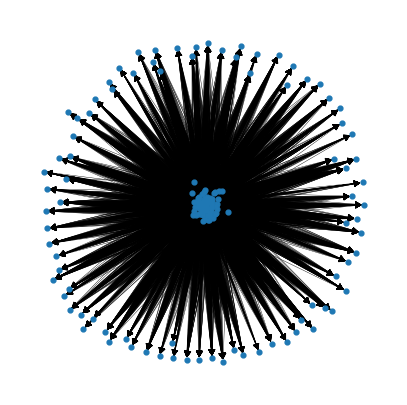

In [29]:
#Draw the network
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
nx.draw_networkx(
    G, 
    ax=ax, 
    with_labels=False,
    node_size=12, 
    width=.3)
ax.set_axis_off()

Check for the average clustering and transitivity of the netwrok. The results show that the network has a high average clustering, meaning that neighboring countries tend to form clusters, however the average transitivity is moderate, which means that on global scale the network is less connected compared to its local connectivity which is higher.

In [30]:
nx.average_clustering(G)

0.8203340987796952

In [31]:
nx.transitivity(G)

0.5862653279365129

### 5.Centrality Analysis 

In this section is explored the importance and role of each country within the global trade netwrok. This is done through measures such as __degree centrality, closeness centrality, betweeness centrality and eigenvector centrailty__. According to (Antonietti et al., 2022) these centrality measures are fit for analysing countires trade relationships. These measures are analysed through __NetworkX, Matplotlib,__ and __Pandas__ packages.

- Degree centrality identifies the countries with the most trade connections, which can be interpreted as their direct influence.

- Closeness centrality measures how easily can a country reach others, which can indicate whether importing countries have efficient access to their partners.

- Betweenes centrality can help identify countries who act as intermediaries, for example countries who facilitate trades between other countries that are not directly connected.

- Eigenvector centrailty measures not only the direct connections a country has but also the indirect ones, such as what are the connections to other well-connected countries. As such it measures the influence of a country. 


In [32]:
deg = nx.degree_centrality(G)
close = nx.closeness_centrality(G)
bet = nx.betweenness_centrality(G)
eig = nx.eigenvector_centrality(G)
metrics = [deg,close,bet,eig]
metrics_label = ['Degree Centrality','Closeness Centrality','Betweeness Centrality','Eigenvector Centrality']

In [33]:
#scale the node sizes based on trade value
trade_values = {node: sum(data['TradeValue_EndYear'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()}
node_sizes = list(trade_values.values())

#normalize the node sizes to help with vizualization
min_size, max_size = 100, 1000
norm_node_sizes = np.interp(node_sizes, (min(node_sizes), max(node_sizes)), (min_size, max_size))

In [34]:
#position the nodes in line with their longitude and latitude in the graph
pos = {}
for index, row in country_code.iterrows():
        pos[row['Alpha-3 code']] = (row['Longitude (average)'], row['Latitude (average)'])   

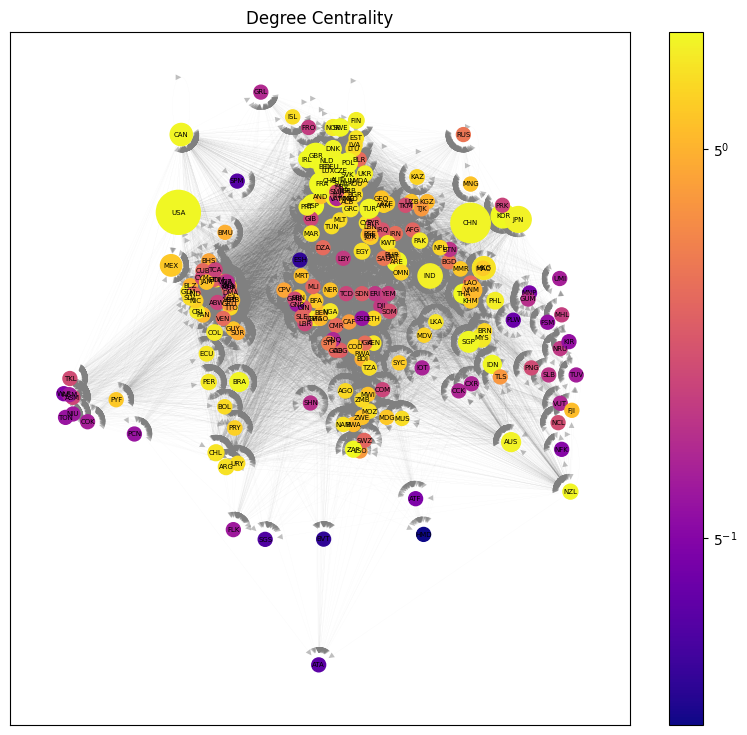

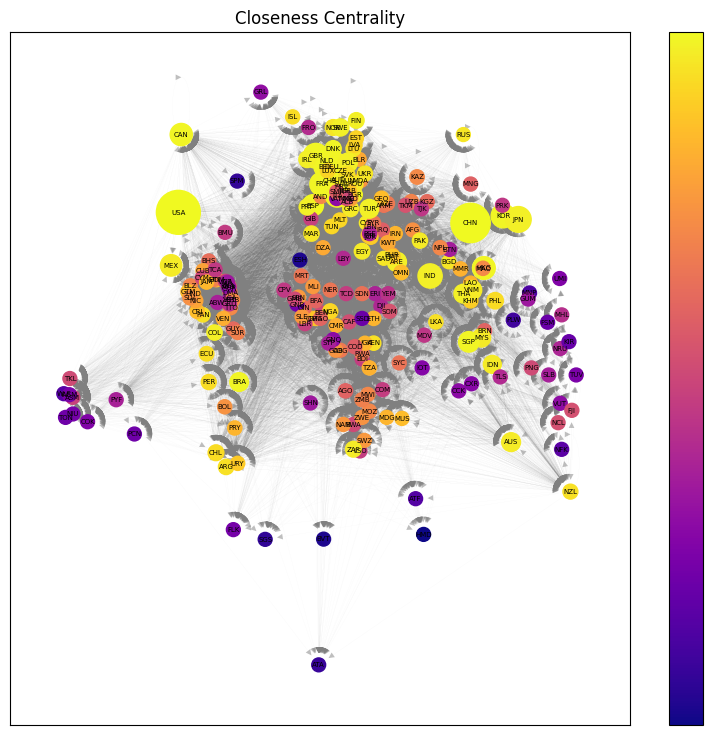

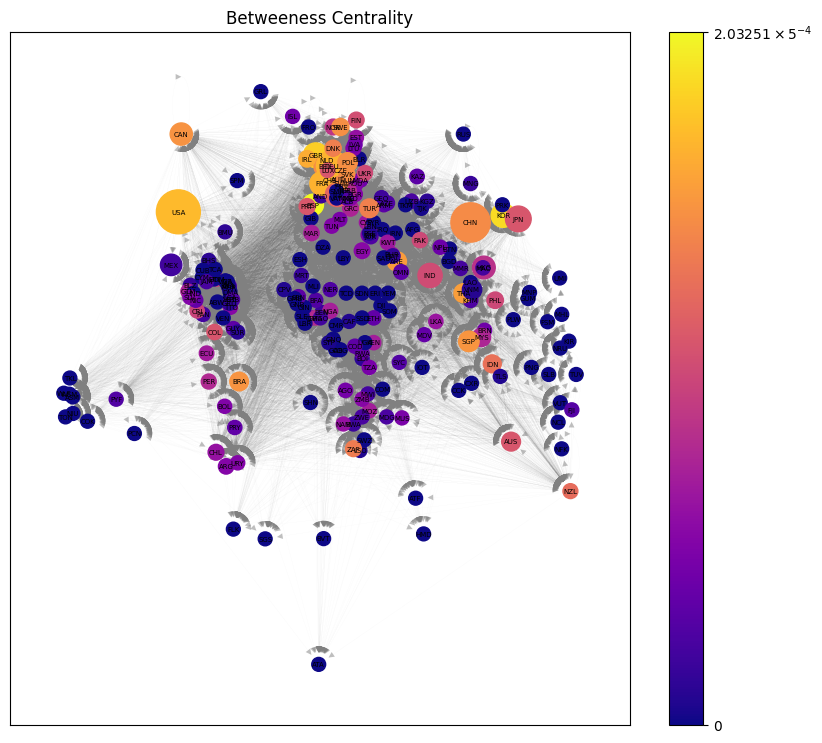

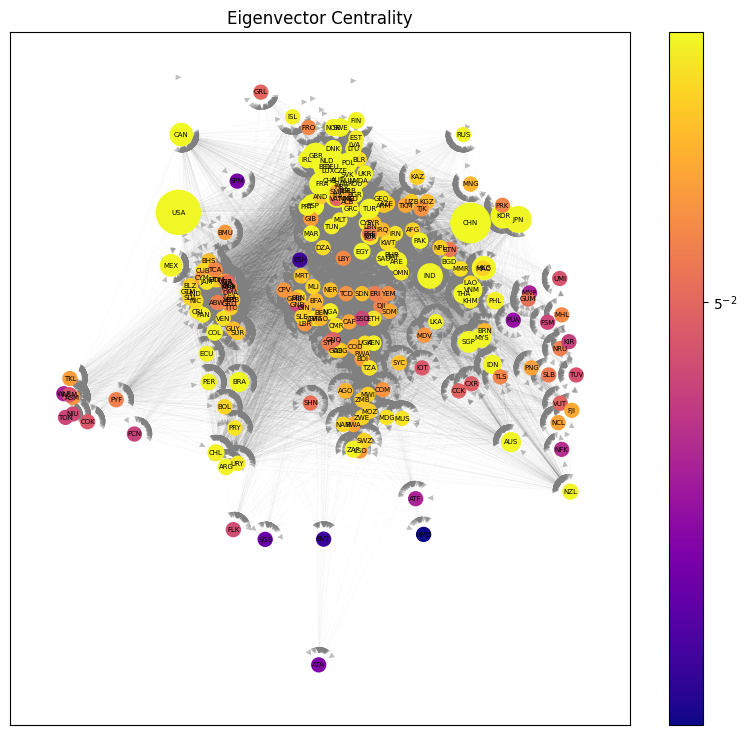

In [35]:
for x in range(len(metrics_label)):  
    fig = plt.figure(figsize=(10,9)) 
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(
        G, 
        pos=pos,
        node_size=norm_node_sizes,           
        cmap=plt.cm.plasma,                    
        node_color=list(metrics[x].values()), 
        nodelist=metrics[x].keys()            
    )
    
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=5))
   
   # Draw labels and edges
    labels = nx.draw_networkx_labels(
        G, 
        pos=pos,
        font_size=5)
    
    edges = nx.draw_networkx_edges(
        G, 
        pos=pos, 
        alpha = 0.5,
        width= 0.02,
        edge_color = 'gray')    
    
    # Set title and color bar for the nodes
    plt.title(metrics_label[x])
    plt.colorbar(nodes)
    plt.show()

The centrality measure can be checked individually as well. This can be useful when one particular country's influence or relationships needs to be analysed

In [36]:
eig['RUS']

0.08046234703748227

In [37]:
eig['USA']

0.08183303307429897

In [38]:
deg['CHN']

1.5526315789473684

In [39]:
deg['MEX']

1.162280701754386

In [40]:
close['AUS']

0.6143054554193703

In [41]:
close['FRA']

0.6228374756335282

In [42]:
bet['USA']

0.002766556951060388

In [43]:
bet['ITA']

0.0019636416883846517

### 6.Visualisation of import trades of top 50 countries

In this section is vizualised the network of the top 50 importing countries. Based on the previous section which explored the centrality analysis of the countries, it was identified that certain countries consistently emerged as top players in global import trades in the year of 2022. For example, the countries with highest degree centrality have been identified to also have high closeness and high eigenvector centraility. This implies that there are top players when it comes to a global trade netwrok. 

As such, in this section the top 50 importing countries are identified based on weighted eigenvector, where total trade value is used as weights. Then, once these countries are identified, a subgrapgh is created which showcases the network of these countries trade. And lastly, the network is vizualised on a map. 

This is done through using __NetworkX__, __Pandas__, __Cartopy__ packages.
More information on Cartopy package can be found here:
https://pypi.org/project/Cartopy/


In [44]:
# Calculate weighted eigenvector centrality- using trade values as weights
weighted_eigenvector_centrality = nx.eigenvector_centrality(G, weight='TradeValue_EndYear', max_iter=1000)

# Extract and sort the top 50 nodes for eigenvector centrality
top_50_countries_eig = sorted(weighted_eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:51]

# Create a DataFrame for top countries
top_import_countries = pd.DataFrame(top_50_countries_eig, columns=["Node", "Weighted Eigenvector Centrality"])

# Display the results
print(top_import_countries)

   Node  Weighted Eigenvector Centrality
0   CHN                         0.633198
1   USA                         0.380741
2   JPN                         0.243777
3   KOR                         0.234949
4   CAN                         0.225546
5   DEU                         0.224227
6   MEX                         0.217788
7   AUS                         0.151364
8   VNM                         0.146468
9   MYS                         0.131250
10  RUS                         0.118359
11  BRA                         0.110477
12  SAU                         0.100223
13  ITA                         0.096451
14  IDN                         0.095014
15  FRA                         0.093846
16  THA                         0.091902
17  CHE                         0.088607
18  IND                         0.075472
19  NLD                         0.072773
20  GBR                         0.071897
21  ARE                         0.063384
22  IRL                         0.062177
23  SGP         

In [45]:
top_import_countries.to_csv('top_import_countries.csv', index=False)

In [46]:
top_import_countries.shape

(51, 2)

In [47]:
# Get the list of top nodes
top_nodes = top_import_countries['Node'].tolist()

# Create a subgraph from the original graph G using only the top nodes
top_subgraph = G.subgraph(top_nodes)

In [48]:
labels = {node: node for node in top_subgraph.nodes()}
node_sizes=[300 * top_import_countries[top_import_countries['Node'] == node]['Weighted Eigenvector Centrality'].values[0] for node in top_subgraph.nodes()]

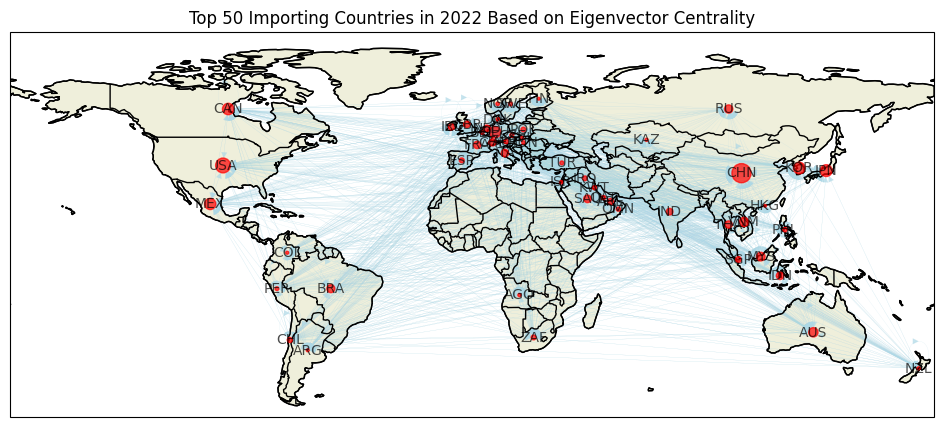

In [49]:
#Map projection
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, figsize=(12, 5),
    subplot_kw=dict(projection=crs))

ax.coastlines()
ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
#Add countries
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, edgecolor='black')

# Draw the subgraph
nx.draw_networkx(
    top_subgraph, 
    ax=ax,
    pos=pos,
    font_size=10,
    alpha=0.7,
    width=0.1,
    labels=labels,
    node_size=node_sizes,
    node_color='red',
    edge_color='lightblue'
)


# Show the plot
plt.title('Top 50 Importing Countries in 2022 Based on Eigenvector Centrality')
plt.show()


In [50]:
fig.savefig('top 50 importing countries.png')

Zooming into the European continent and the Arabian Peninsula for better view as in the previous map this countries are crowded

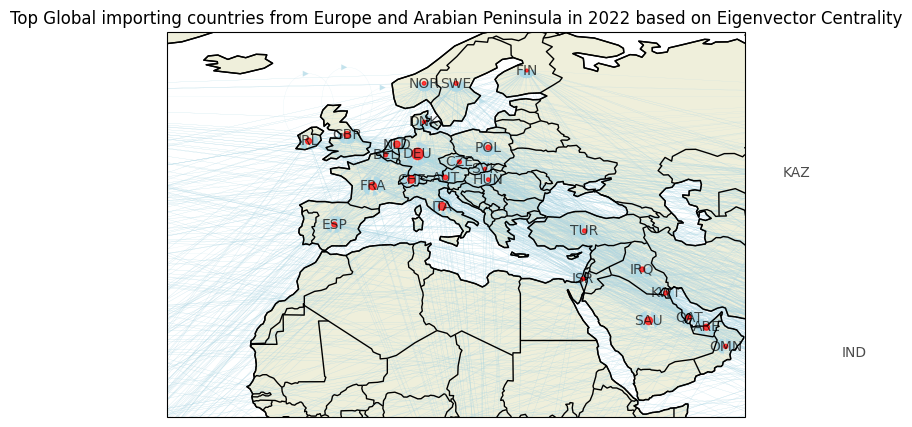

In [51]:
#Map projection
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, figsize=(12, 5),
    subplot_kw=dict(projection=crs))

ax.coastlines()
ax.set_extent([-30, 60, 10, 70], crs=ccrs.PlateCarree())
#Add countries
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, edgecolor='black')

# Draw the subgraph
nx.draw_networkx(
    top_subgraph, 
    ax=ax,
    pos=pos,
    font_size=10,
    alpha=0.7,
    width=0.1,
    labels=labels,
    node_size=node_sizes,
    node_color='red',
    edge_color='lightblue'
)


# Show the plot
plt.title('Top Global importing countries from Europe and Arabian Peninsula in 2022 based on Eigenvector Centrality')
plt.show()

In [52]:
fig.savefig('Europe and Saudi Arabia.png') 

### 7.Top Markets for the top 10 importing countries in 2022

This sections analyses the top markets for the top 10 importing countries in 2022. By narrowing down to the top 10 countries, the granularity of the analysis is increased, which allows a closer examination of trade relationships between the most influencial countries. 
This part builds from the previous vizualisation of the top 50 importers by providing insights into the most influential relationships in the global trade netwrok. 

Specifially this sections allows to see which countries are driving the largest proportion of imports and how they interact with other major economies in the network. First, it is selected the top 10 importing countries from previous dataframe, then it is identified the top markets for those importing countries, and lastly it is vizualised for each individual importing country who their top markets are using a bar chart. 

In [53]:
#create a mapping dictionary from alpha-3 codes to country names so that the names of countries can be shown on the grapgh
country_names = dict(zip(country_code['Alpha-3 code'], country_code['Country']))

#select the top 10 importers from previous dataframe which explored top 50 countries based on weighted eigenvector centrality
top_10_importers = top_import_countries.head(10)["Node"].tolist()

In [54]:
#Create a dictionary to store each importer's top markets
top_markets = {}

#find the top 5 markets for the 10 importers
for importer in top_10_importers:
    importer_data = new_trades[new_trades["ReporterISO3"] == importer]
    top_partners = importer_data.sort_values(by="TradeValue_EndYear", ascending=False).head(5)
    top_markets[importer] = top_partners[["PartnerISO3", "TradeValue_EndYear"]]


In [55]:
top_markets_named = {}

for importer, partners in top_markets.items():
# Get importer name
    importer_name = country_names.get(importer, importer)
# Copy partners data and map to country names
    partners_named = partners.copy()
    partners_named["PartnerCountry"] = partners["PartnerISO3"].map(lambda x: country_names.get(x, x))
    top_markets_named[importer_name] = partners_named[["PartnerCountry", "TradeValue_EndYear"]]

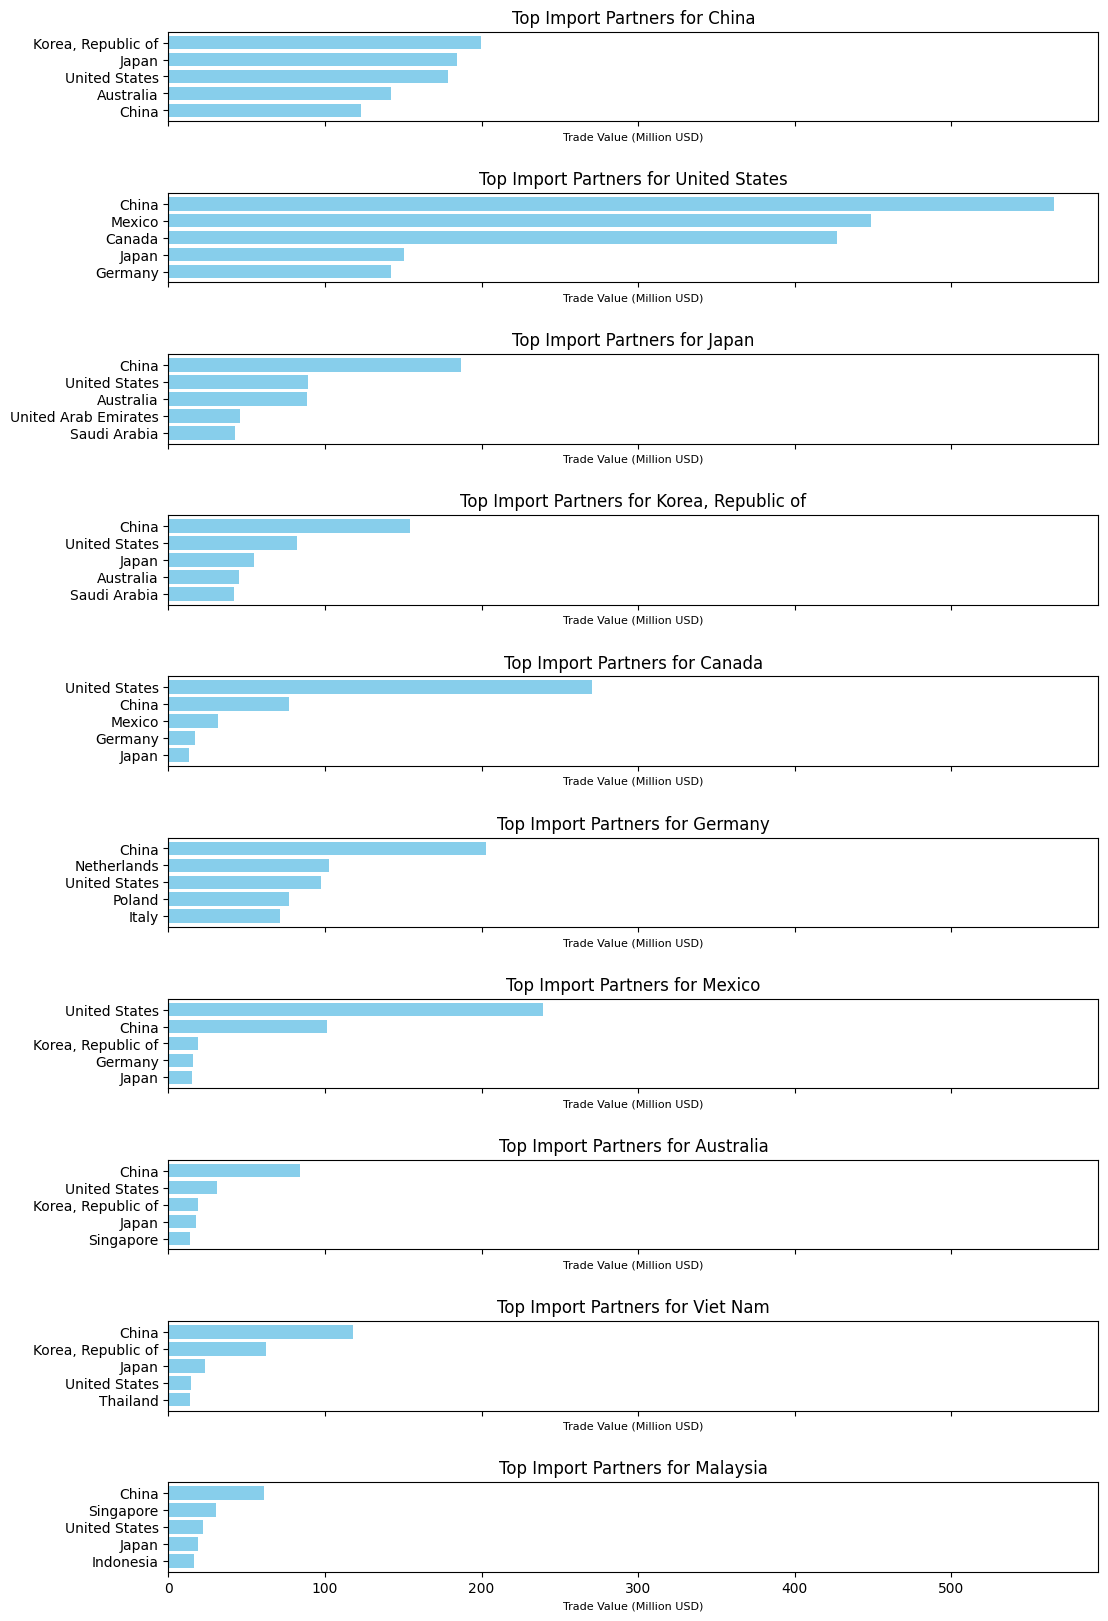

In [56]:
#Plot the horizontal bar charts 
fig, axes = plt.subplots(len(top_markets_named), 1, figsize=(12, 20), sharex=True)

for i, (importer_name, importer_data) in enumerate(top_markets_named.items()):
    importer_data = importer_data.sort_values(by="TradeValue_EndYear", ascending=True)
    trade_values_millions = importer_data["TradeValue_EndYear"] / 1_000_000   
    axes[i].barh(importer_data["PartnerCountry"], trade_values_millions, color="skyblue")
    axes[i].set(title=f"Top Import Partners for {importer_name}")
    axes[i].set_xlabel("Trade Value (Million USD)", fontsize=8)

plt.subplots_adjust(hspace=0.8)  
plt.show()


                                                                                                                   Figure 8

In Figure 8, it can be seen the top 10 importing countries in 2022 and their top markets where they have imported the goods. This chart essentially shows the top exporters for each 10 top importing countries in 2022.
From the chart it can be noticed that the United States in terms of absolute value in trades, has imported the most in 2022, followed by China. 

But another important factor that can be deducted is that there is a clear relationship between importing countries, as their trading partners or top markets where they import the goods from are often nations that rank among the world's top importers. This shows that there are trade partnerships in place, which ensure that top importing countries have the infrastructure and agreements in place to manage significant exports. This patern occurs because largest economies tend to have both high production capacity and high production needs. (Sugita, Teshima and Seira, 2021)

And third factor it can be noticed that the top markets for the importing countries are often neighboring countries, which also has been proved earlier in the analysis where countries with high closeness centraility have also scored high in the eigenvector centraility for example Mexico, United States, Canada, or the European countries

### 8.References


Antonietti, R., Falbo, P., Fontini, F., Grassi, R. and Rizzini, G. (2022). The world trade network: country centrality and the COVID-19 pandemic. Applied Network Science, 7(1). doi:https://doi.org/10.1007/s41109-022-00452-4.

Bacsi, Z., Fekete-Farkas, M. and Ma’ruf, M.I. (2023). A Graph-Based Network Analysis of Global Coffee Trade—The Impact of COVID-19 on Trade Relations in 2020. Sustainability, [online] 15(4), p.3289. doi:https://doi.org/10.3390/su15043289.

Kelechava, B. (2020). ISO Country Codes - Standards in the ISO 3166 Series. [online] The ANSI Blog. Available at: https://blog.ansi.org/2020/10/iso-country-codes-iso-3166-standards/ [Accessed 9 Nov. 2024].

NetworkX (n.d.). NetworkX — NetworkX documentation. [online] networkx.org. Available at: https://networkx.org/.

PyPI. (n.d.). Cartopy 0.19.0.post1 : A cartographic python library with Matplotlib support for visualisation. [online] Available at: https://pypi.org/project/Cartopy/.

      
Sugita, Y., Teshima, K. and Seira, E. (2021). Assortative Matching of Exporters and Importers. The Review of Economics and Statistics, pp.1–46. doi:https://doi.org/10.1162/rest_a_01114.

The pandas development team (n.d.). Package overview — pandas 1.1.5 documentation. [online] pandas.pydata.org. Available at: https://pandas.pydata.org/docs/getting_started/overview.html.